<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/ARMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An ARMA model, or Autoregressive Moving Average model, is used to describe weakly stationary stochastic time series in terms of two polynomials. The first of these polynomials is for autoregression, the second for the moving average.

Often this model is referred to as the ARMA(p,q) model; where:

* p is the order of the autoregressive polynomial,
* q is the order of the moving average polynomial.

The equation is given by:

\begin{align}
        \mathbf{x_t} = \mathbf{w_t} + \sum_{i=1}^q \alpha_i x_{t-i} + \sum_{i=1}^p \beta_i w_{t-i}
        &
    \end{align}


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from time import time
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Vizualise the Stock Price Over Time

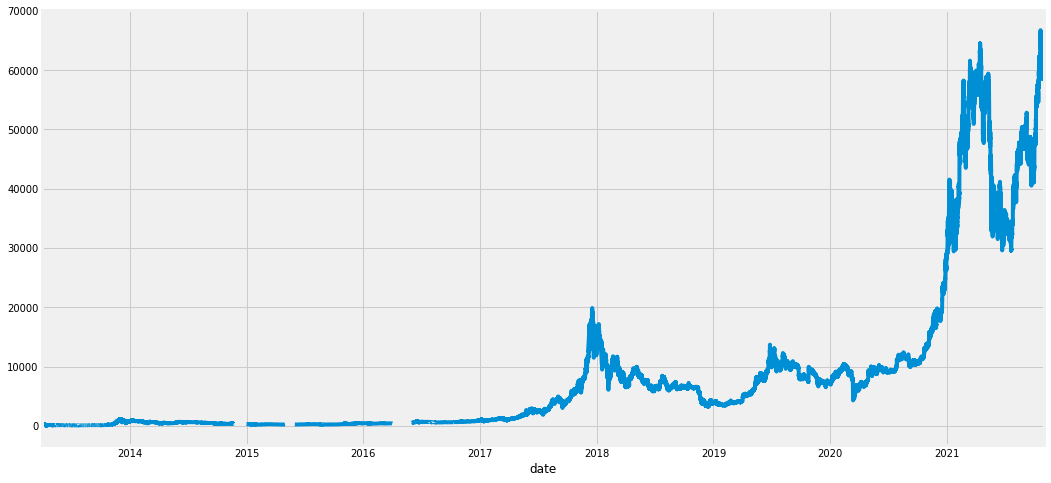

In [3]:
#read data
df = pd.read_csv('/content/drive/MyDrive/Yoctobe Fintech/Datasets/btcusd30mn.csv', parse_dates=True)
df.head()
# #setting index as date because some statsmodels might not work
df.rename(columns={'datetime': 'date'}, inplace=True)
df.index = df['date']
df.index = pd.to_datetime(df.index)
#plot
df['close'].plot(figsize=(16,8))

In [4]:
df = df.drop(columns =['open', 'high', 'low', 'volume', 'date'])
df.head()

,close
date,
2013-04-01 00:00:00,94.120499
2013-04-01 00:30:00,93.250000
2013-04-01 01:00:00,93.422576
2013-04-01 01:30:00,93.100000
2013-04-01 02:00:00,93.189997


# Identify the correct ARMA Model Order
## Visualising ACF Plot and PACF Plots
The bars inside the blue shaded region then they are not statistically significant.
* PACF is the autocorrelation that is just associated with just k lags
* PACF cuts off after lag k = q; ACF cuts off after lag k = p; 

"Cuts off" means that it becomes zero abruptly, and "tails off" means that it decays to zero asymptotically (usually exponentially).

The PACF "cuts off" after the 2nd lag, while the ACF "tails off" to zero. You probably have something like an AR(2).



In [30]:
ddf = df.resample("D").mean()
# using a range of dates
mask = (ddf.index > '2020-01-01') & (ddf.index <= '2021-01-01')
ddf = ddf.loc[mask]

# Tain Dataset

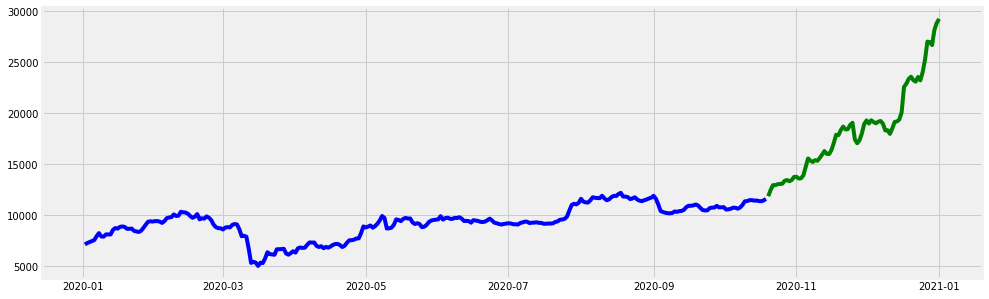

In [46]:
# using scikitlearn to split the dataset into 80% training and 20% validation datasets 
df_train, df_valid = train_test_split(ddf, train_size = 0.8, shuffle=False)

plt.figure(figsize=(15,5))
plt.plot(df_train, color='blue')
plt.plot(df_valid, color='green')


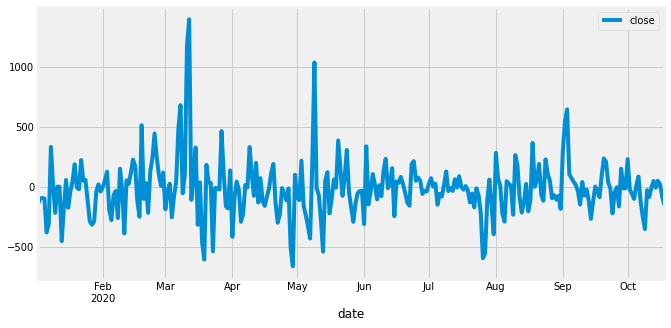

In [47]:

# Difference the stock price and make it stationary
# A stationary process has the property that the mean, 
# variance and autocorrelation structure do not change over time.
df1_train = df_train - df_train.shift(-1)
df1_train.dropna(inplace=True)
df1_train.plot(figsize = (10,5))


# Stationarity
Mathimatically, stationarity of a time series is defined as the requirement that for every m and n, the distributions: \begin{align}
        \mathbf (Y_1, Y_2, Y_3, ..., Y_n) \\and\\  (Y_{1+m}, Y_{2+m}, Y_{3+m}, ..., Y_{n+m})
        &
    \end{align} are the same.

Strong stationarity : all the aspects of the stochastic process remain unchanged, constant in time.
Weak stationarity : only mean, variance, and covariance remain unchanged.
The simplest example of weakly stationary process is White Noise defined with increasingly restrictive assumptions: 
\begin{align}
 \mathbf E(Y_t) = {μ} \\  Var(Y_t) = σ^2 \\  Cov(Y_t, Y_s) = 0
        &
    \end{align}

Where the best predictor is the Mean.

##Dickey–Fuller test
Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive time series model.

Augmented Dickey-Fuller Test: The time series is considered stationary if the p-value is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistics.

In [48]:
#test stationarity
print('Results of Dickey-Fuller Test:')
dftest = sm.tsa.adfuller(df1_train['close'])
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -8.226138e+00
p-value                        6.239124e-13
#Lags Used                     2.000000e+00
Number of Observations Used    2.880000e+02
Critical Value (1%)           -3.453262e+00
Critical Value (5%)           -2.871628e+00
Critical Value (10%)          -2.572146e+00
dtype: float64


## Roling Mean


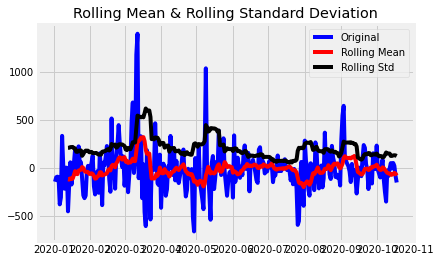

In [78]:
rolling_mean = df1_train.rolling(window = 12).mean()
rolling_std = df1_train.rolling(window = 12).std()
plt.plot(df1_train, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

# Plot ACF PACF

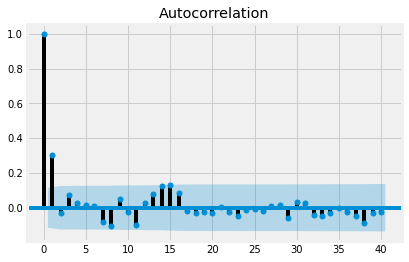

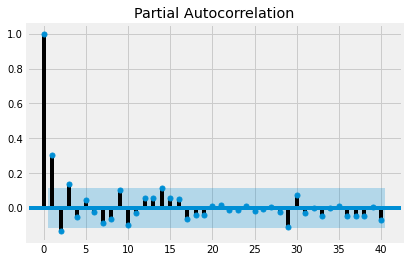

In [49]:
acf = sm.tsa.graphics.plot_acf(df1_train['close'], lags=40)
pacf = sm.tsa.graphics.plot_pacf(df1_train['close'], lags=40)

In [50]:
#By selecting aic as criteria, decide the order.
sm.tsa.stattools.arma_order_select_ic(df1_train['close'], ic='aic')

{'aic':              0            1            2
 0  3998.736128  3963.975544  3964.102335
 1  3972.587654  3963.575997  3965.333678
 2  3969.430597  3965.254415  3966.898655
 3  3966.059389  3966.894894  3968.778571
 4  3967.374601  3968.602647  3970.595153, 'aic_min_order': (1, 1)}

In [70]:
#fit the model_1
mod = sm.tsa.ARIMA(df_train['close'], order = (1,1, 1), freq='D')
result = mod.fit()
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  291
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1977.788
Method:                       css-mle   S.D. of innovations            216.423
Date:                Fri, 12 Nov 2021   AIC                           3963.576
Time:                        13:40:58   BIC                           3978.269
Sample:                    01-03-2020   HQIC                          3969.462
                         - 10-19-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            15.5789     16.475      0.946      0.345     -16.712      47.869
ar.L1.D.close    -0.2326      0.142     -1.635      0.103      -0.512       0.046
ma.L1.D.close     0.6017      0.119     

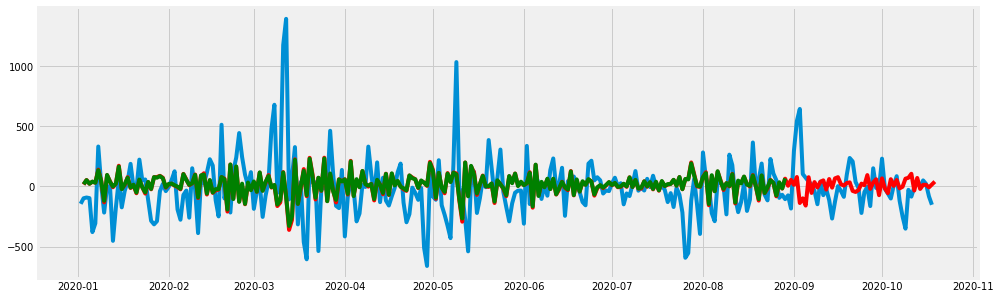

In [71]:
plt.figure(figsize=(15,5))
plt.plot(df1_train)
plt.plot(result.fittedvalues, color='red')
plt.plot(result1.fittedvalues, color='green')
plt.show()

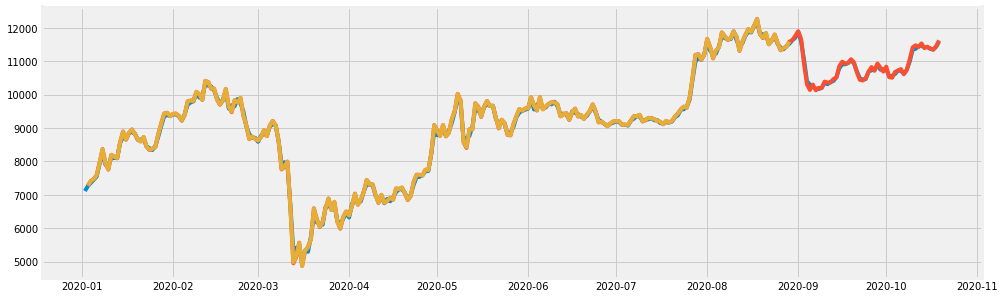

In [72]:
#take back to original scale
df_estimated = pd.DataFrame(result.fittedvalues,columns=['close'],copy=False)
df_origin = df_estimated['close'] + df_train['close']
df_origin.dropna(inplace=True)

#take back to original scale model_2
df1_estimated = pd.DataFrame(result1.fittedvalues,columns=['close'],copy=False)
df1_origin = df1_estimated['close'] + df_train['close']
df1_origin.dropna(inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df_train['close'])
plt.plot(df_origin)
plt.plot(df1_origin)
plt.show()

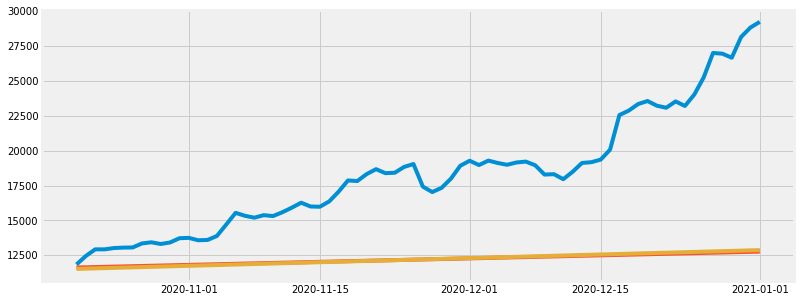

In [73]:
#make predictions and compared it to the validation dataset
forecast = pd.DataFrame(result.forecast(len(df_valid['close']))[0],
                        columns=['forecasted values'], index=df_valid.index)

#make predictions and compared it to the validation dataset
forecast1 = pd.DataFrame(result1.forecast(len(df_valid['close']))[0],
                        columns=['forecasted values'], index=df_valid.index)

plt.figure(figsize=(12,5))
plt.plot(df_valid['close'])
plt.plot(forecast['forecasted values'])
plt.plot(forecast1['forecasted values'])
plt.show()

In [74]:
df_diff = ddf - ddf.shift(-1)
df_diff.dropna(inplace = True)

#fit the model to the whole dataset
model_final = sm.tsa.ARIMA(ddf['close'], order = (1,1,2), freq = 'D')
result_final = model_final.fit()
print(result_final.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  365
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2610.823
Method:                       css-mle   S.D. of innovations            308.967
Date:                Fri, 12 Nov 2021   AIC                           5231.645
Time:                        13:41:19   BIC                           5251.145
Sample:                    01-03-2020   HQIC                          5239.395
                         - 01-01-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            97.3802     77.567      1.255      0.210     -54.649     249.410
ar.L1.D.close     0.9891      0.015     66.975      0.000       0.960       1.018
ma.L1.D.close    -0.5999      0.055    -

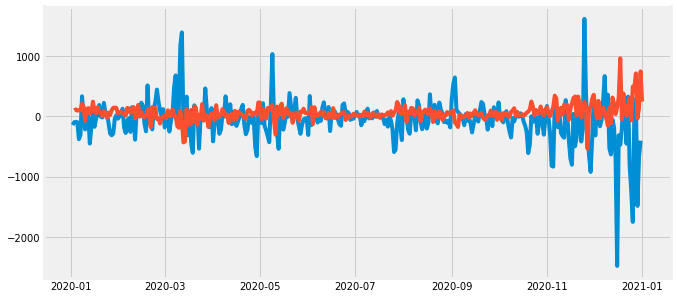

In [75]:
plt.figure(figsize=(10,5))
plt.plot(df_diff)
plt.plot(result_final.fittedvalues)
plt.show()

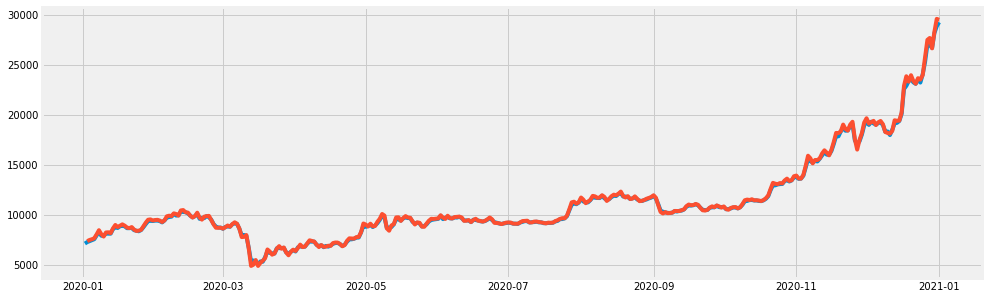

In [76]:
df_estimated_final = pd.DataFrame(result_final.fittedvalues,columns=['close'],copy=False)
df_origin_final = df_estimated_final['close'] + ddf['close']
df_origin_final.dropna(inplace=True)
plt.figure(figsize=(15,5))
plt.plot(ddf['close'])
plt.plot(df_origin_final)
plt.show()

,close,forcasted
date,,
2020-01-02,7114.988529,29560.876134
2020-01-03,7259.342922,29831.483056
2020-01-04,7357.616746,30100.208042
2020-01-05,7449.490750,30367.071538
2020-01-06,7546.358015,30632.093766


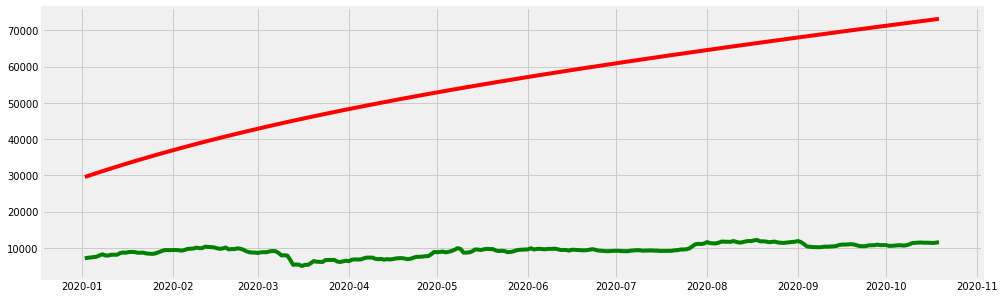

In [77]:
result_actual = df_train.resample('D').mean()
forcast_date_range = result_actual.index.to_numpy()
forcast_date_range
forecast_final = pd.DataFrame(result_final.forecast(steps=len(forcast_date_range))[0], columns= ['forcasted'], index=forcast_date_range)
plt.figure(figsize=(15,5))
result_actual['forcasted'] = forecast_final['forcasted']
plt.plot(result_actual['forcasted'], color = 'red')
plt.plot(result_actual['close'], color = 'green')
result_actual.head()